### Prepare domain GRU shapefile ###
This step includes:
1. extract domain GRU shapefile from a large-domain HUC12 shapefile.  <br> 
   Note: this step is not needed if the basin shapefile exists already and is put in 'domain_gru_shp' setting of control file.
2. project domain GRU shapefile to a specified projection system.

In [10]:
# import libraries
import os
import geospatial_functions.utils as ut
import geospatial_functions.geospatial_analysis as ga
import rasterio as rio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 

In [11]:
# paths
control_file = 'control_active.txt'
root_path = ut.read_from_control(control_file, 'root_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
domain_path = os.path.join(root_path, domain_name)

In [ ]:
# projection system
proj4=ut.read_from_control(control_file, 'proj4') 
dst_crs = rio.crs.CRS.from_string(proj4)

In [12]:
# large-domain data 
huc12_shp = ut.read_from_control(control_file, 'huc12_shp')
huc12_field   = ut.read_from_control(control_file, 'huc12_field')      
Tohuc12_field = ut.read_from_control(control_file, 'Tohuc12_field')
outlet_hucid  = ut.read_from_control(control_file, 'outlet_hucid')

gruNo_field = ut.read_from_control(control_file, 'gruNo_field')
gruNo_field_dtype= ut.read_from_control(control_file, 'gruNo_field_dtype')
gruName_field = ut.read_from_control(control_file, 'gruName_field')

# domain data 
domain_gru_shp = ut.specify_file_path(control_file, 'domain_gru_shp')  
domain_hucid_txt = ut.specify_file_path(control_file, 'domain_hucid_txt')   
domain_gru_prj_shp = ut.specify_file_path(control_file, 'domain_gru_prj_shp')  

#### 1. Extract domain GRU shapefile from the large-domain HUC12 shapefile ####

In [5]:
# Function to find the unique items of a list
def unique(list1):
    list_uniqe = []
    for x in list1:
        if not x in list_uniqe:
            list_uniqe.append(x)
    return list_uniqe

In [6]:
# ---- read large-domain HUC12 shapefile ---- 
data = gpd.read_file(huc12_shp)
# check whether two useful columns (huc12_field, Tohuc12_field) are in huc12_shp.
if not huc12_field in data.columns.values:
    exit(huc12_field+' column does not exist in shapefile.')
else:
    hucs = data[huc12_field].values
if not Tohuc12_field in data.columns.values:
    exit(Tohuc12_field+' column does not exist in shapefile.')
else:
    tohucs = data[Tohuc12_field].values
# extract only the useful columns to save data memory.
data = data[[huc12_field,Tohuc12_field,'geometry']] 

# ---- search upstream HUCs ---- 
# method 1: search upstream hucs base on the most downstream hucId
upstream_hucs = [outlet_hucid]                              # list of upstream hucs. initiate with outlet_hucid
huc_found = np.unique(hucs[np.where(tohucs==outlet_hucid)]) # find all the upstream hucs that drain to outlet_hucid.
upstream_hucs.extend(list(huc_found))                       # add the found upstream hucs of outlet_hucid to upstream_hucs list. 
round_num = 0                                               # record the round number of searching.

while len(huc_found) != 0: # terminate searching upstream hucs until no one can be found any more.

    round_num = round_num+1
    print("Round %d. Totally %d HUCs are found." % (round_num, len(upstream_hucs)))

    # search upstream hucs
    huc_found_next = []
    for huc_i in huc_found:
        huc_found_next.extend(list(hucs[np.where(tohucs==huc_i)]))
    huc_found_next = unique(huc_found_next)

    # identify if the found HUCs exist in upstrm_hucs
    huc_found = [huc for huc in huc_found_next if not huc in upstream_hucs]
    upstream_hucs.extend(huc_found)

#     # method 2: manually add upstream_hucs when the list of upstream hucs is known. 
#     # here huc12 list is from the bighorn model forcing nc file (hurId).
#     upstream_hucs= np.loadtxt('/glade/u/home/andywood/proj/SHARP/wreg/bighorn/prep/lists/hucIds.06279940.txt',dtype=int)
#     upstream_hucs=[100800120304, 100800120302, 100800120303, 100800120301,100800120209, 100800120207, 100800120204, 100800120205, 100800120208,
#                 100800120206, 100800120105, 100800120201, 100800120202, 100800120203,100800120101, 100800120102, 100800120103, 100800120104]

# ---- save upstream HUC12 to text and shapefile ---- 
np.savetxt(domain_hucid_txt, upstream_hucs, fmt='%s')
data[data[huc12_field].isin(upstream_hucs)].to_file(domain_gru_shp)


Round 1. Totally 3 HUCs are found.
Round 2. Totally 5 HUCs are found.
Round 3. Totally 9 HUCs are found.
Round 4. Totally 14 HUCs are found.
Round 5. Totally 18 HUCs are found.


#### Check domain GRU ####

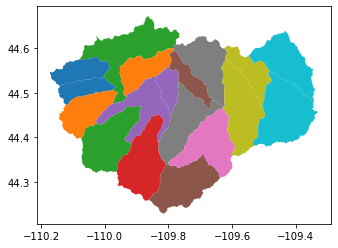

In [13]:
def plot_vector(invector, column):    
    in_gpd = gpd.read_file(invector)
    fig, ax = plt.subplots()
    in_gpd.plot(column=column, ax=ax)
    plt.show()   
    return

plot_vector(domain_gru_shp, huc12_field)

#### 2. Reproject GRU shapefile ####

In [14]:
ga.reproject_vector(domain_gru_shp, domain_gru_prj_shp, dst_crs)  